In [27]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
from matplotlib import rcParams,rc
import control
plt.style.context('seaborn-white')
rcParams['figure.dpi']= 200
# rcParams['font.family'] = 'serif'
# rc('text', usetex=True)


In [28]:
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"

In [29]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = np.array2string(a, max_line_width=np.infty).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)



In [30]:
A=np.zeros((4,4))
B=np.zeros((4,1))
A[0,1] = 1
A[1,2] = 7.007142857
A[2,3] = 1
A[3,0] = 268.4961091
A[3,2] = -4.967178019
B[3,0]=4.8077/0.0365

print(bmatrix(np.around(A,3)))

\begin{bmatrix}
  0. & 1. & 0. & 0.\\
  0. & 0. & 7.007 & 0.\\
  0. & 0. & 0. & 1.\\
  268.496 & 0. & -4.967 & 0.\\
\end{bmatrix}


In [31]:
C=np.array([[1, 0, 0, 0],[0, 0, 1, 0]])
G=control.place(A.T,C.T,[-20, -20, -21,-21]).T
K=control.place(A,B,[-3,-3.25,-3.75,-4])

print(bmatrix(np.around(G,3)))
print(bmatrix(np.around(K,3)))

\begin{bmatrix}
  41. & -0.\\
  420. & 7.007\\
  -0. & 41.\\
  268.496 & 415.033\\
\end{bmatrix}
\begin{bmatrix}
  2.197 & 0.183 & 0.518 & 0.106\\
\end{bmatrix}


In [32]:
def rownanie_OL(t,y,K,G,A,B,C,cl):
    x=y[:4].reshape((4,1))
    xh=y[4:].reshape((4,1))
    a1=7.007
    a2=0.7143
    b1=0.0365
    b2=0.181485
    b3=4.8077
    g=9.81
    rhs=np.zeros((8,))
    if cl:
        u=-K@np.array([x[0],xh[1],x[2],xh[3]]).reshape((4,1))
    else:
        u=-K@x
    if np.abs(u)>5:
         u=np.sign(u)*5

    rhs[0] = x[1]
    rhs[1] = a1*np.sin(x[2])+a2*x[0]*x[3]**2
    rhs[2] = x[3]
    rhs[3] = (g*x[0]*np.cos(x[2])-b2*np.sin(x[2])+b3*u)/(b1+x[0]**2)
    rhs[4:] = (A@xh+G@C@(x-xh)+B*u).reshape((4,))

    return rhs
lin_obs_ol = lambda t,y : rownanie_OL(t,y,K,G,A,B,C,False)
lin_obs_cl = lambda t,y : rownanie_OL(t,y,K,G,A,B,C,True)


In [33]:
def rownanie_ON(t,y,K,G_n,C,cl):
    x=y[:4].reshape((4,1))
    xh=y[4:].reshape((4,1))
    a1=7.007
    a2=0.7143
    b1=0.0365
    b2=0.181485
    b3=4.8077
    g=9.81
    rhs=np.zeros((8,))
    if cl:
        u=-K@np.array([x[0],xh[1],x[2],xh[3]]).reshape((4,1))
    else:
        u=-K@x
    if np.abs(u)>5:
         u=np.sign(u)*5

    rhs[0] = x[1]
    rhs[1] = a1*np.sin(x[2])+a2*x[0]*x[3]**2
    rhs[2] = x[3]
    rhs[3] = (g*x[0]*np.cos(x[2])-b2*np.sin(x[2])+b3*u)/(b1+x[0]**2)

    rhs[4] = xh[1]
    rhs[5] = a1*np.sin(x[2])+a2*x[0]*xh[3]**2
    rhs[6] = xh[3]
    rhs[7] = (g*x[0]*np.cos(x[2])-b2*np.sin(x[2])+b3*u)/(b1+x[0]**2)

    leg = G_n@C@(x-xh) #linear error gain
    rhs[4:] = rhs[4:]+leg.reshape((4,))

    return rhs

A_nln =np.diag([1,0,1],1)
G_n=control.place(A_nln.T,C.T,[-20, -20, -21,-21]).T

nln_obs_cl = lambda t,y:rownanie_ON(t,y,K,G_n,C,True)
nln_obs_ol = lambda t,y:rownanie_ON(t,y,K,G_n,C,False)



In [34]:
G_n@C


print(bmatrix(np.around(A_nln-G_n@C,5)))

\begin{bmatrix}
  -41. & 1. & 0. & 0.\\
  -420. & 0. & 0. & 0.\\
  0. & 0. & -41. & 1.\\
  0. & 0. & -420. & 0.\\
\end{bmatrix}


In [35]:
t=np.linspace(0,5,1000)
y0=np.zeros((8,))
x0=np.array([-0.19,0,-0.2,0])
xh0=x0
y0[:4] = x0
y0[4:] = xh0
sol = solve_ivp(fun = lin_obs_cl,t_span=[0,5],y0=y0,t_eval=t,method='RK45',atol=1e-4,rtol=1e-4)

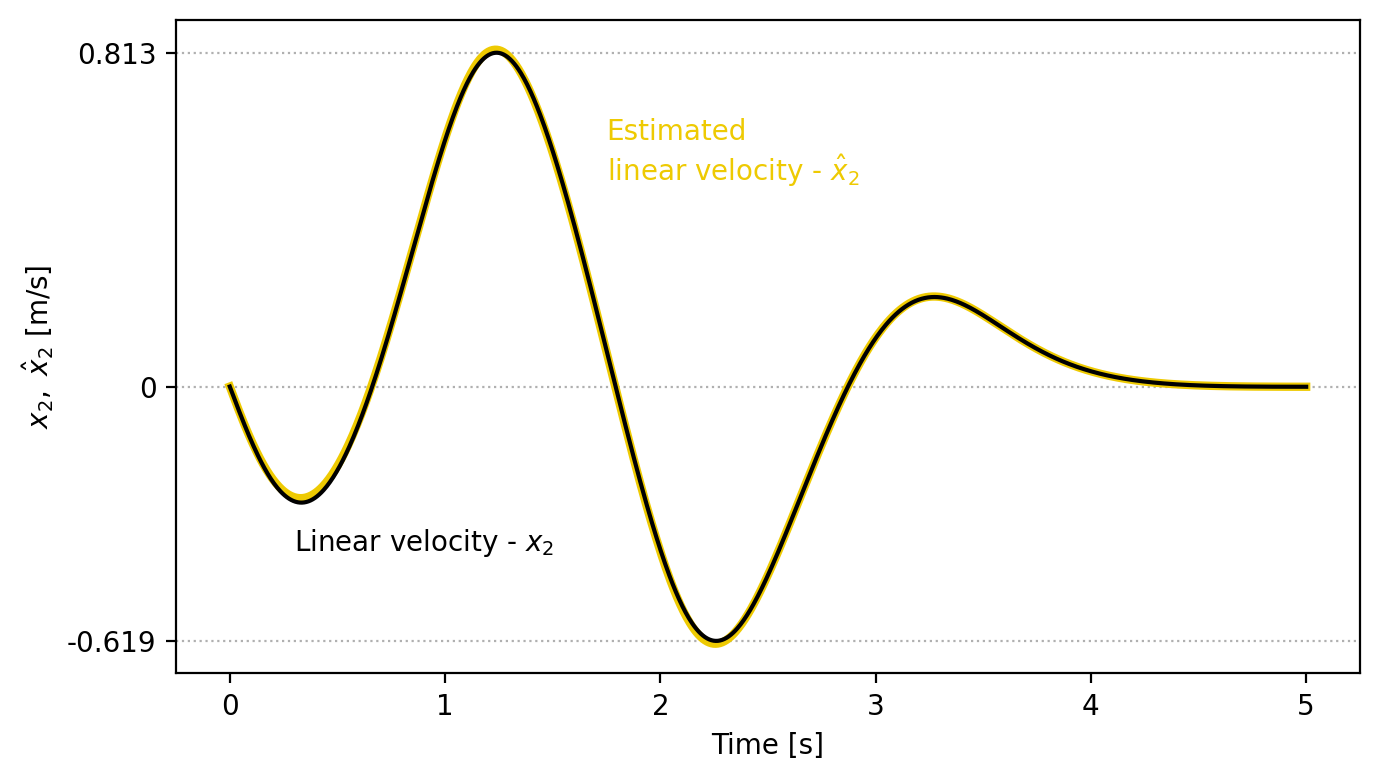

In [36]:


fig1,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[5],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[1],c='black')
ax0.set_yticks([1.0*min(sol.y[1]),0,1.0*max(sol.y[1])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[1])),'0','{:.3f}'.format(1.0*max(sol.y[1]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_2,\\ \\hat{x}_2$ [m/s]')
ax0.text(s='Linear velocity - $x_2$',x=0.3,y=-.4 )
ax0.text(s='Estimated\nlinear velocity - $\\hat{x}_2$',x=1.75,y=0.5,c=DARK )
fig1.tight_layout()
fig1.savefig('linear_cl_x2.pdf')
# ax1.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
# ax1.plot(t,sol.y[3],c='black')

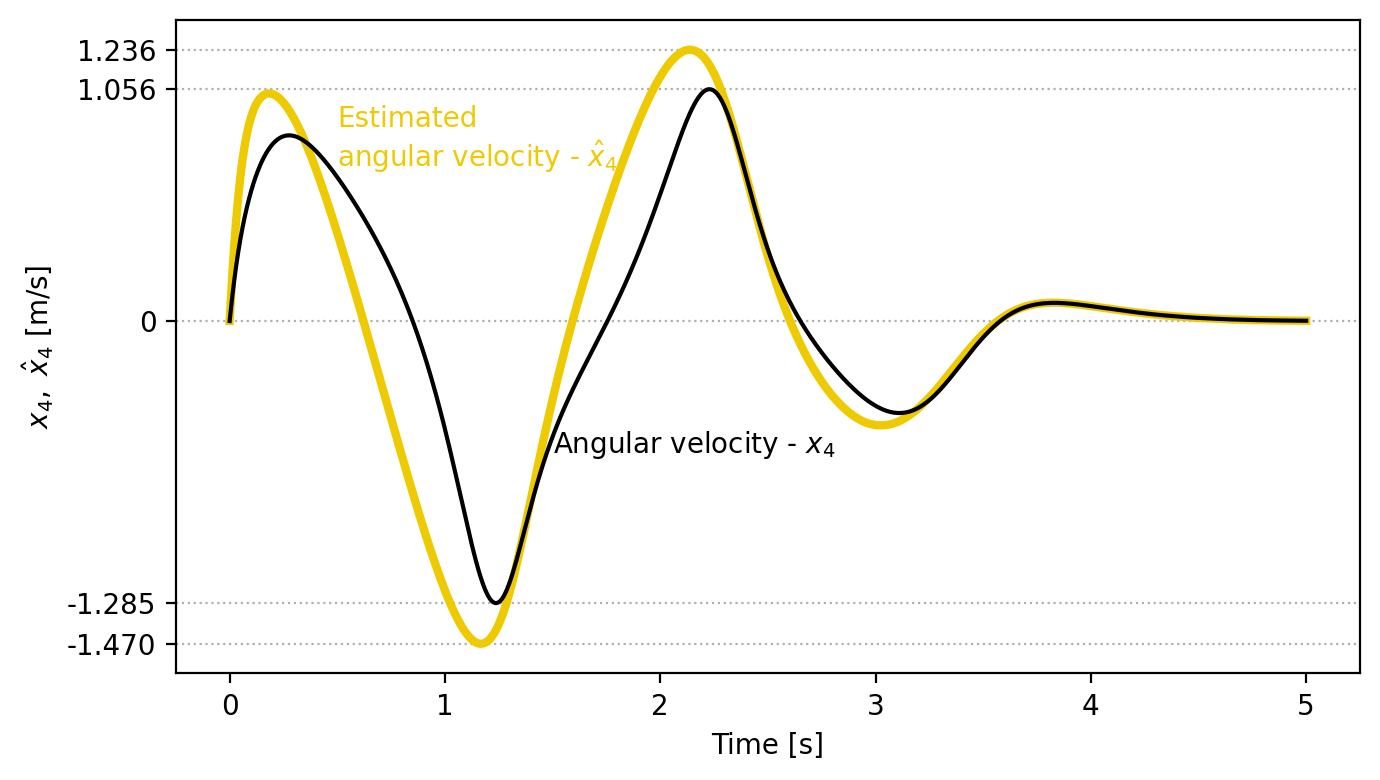

In [37]:
fig2,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[3],c='black')
ax0.set_yticks([1.0*min(sol.y[7]),1.0*min(sol.y[3]),0,1.0*max(sol.y[3]),1.0*max(sol.y[7])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[7])),'{:.3f}'.format(1.0*min(sol.y[3])),'0','{:.3f}'.format(1.0*max(sol.y[3])),'{:.3f}'.format(1.0*max(sol.y[7]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_4,\\ \\hat{x}_4$ [m/s]')
ax0.text(s='Angular velocity - $x_4$',x=1.5,y=-.6 )
ax0.text(s='Estimated\nangular velocity - $\\hat{x}_4$',x=.5,y=0.7,c=DARK )
fig2.tight_layout()
fig2.savefig('linear_cl_x4.pdf')

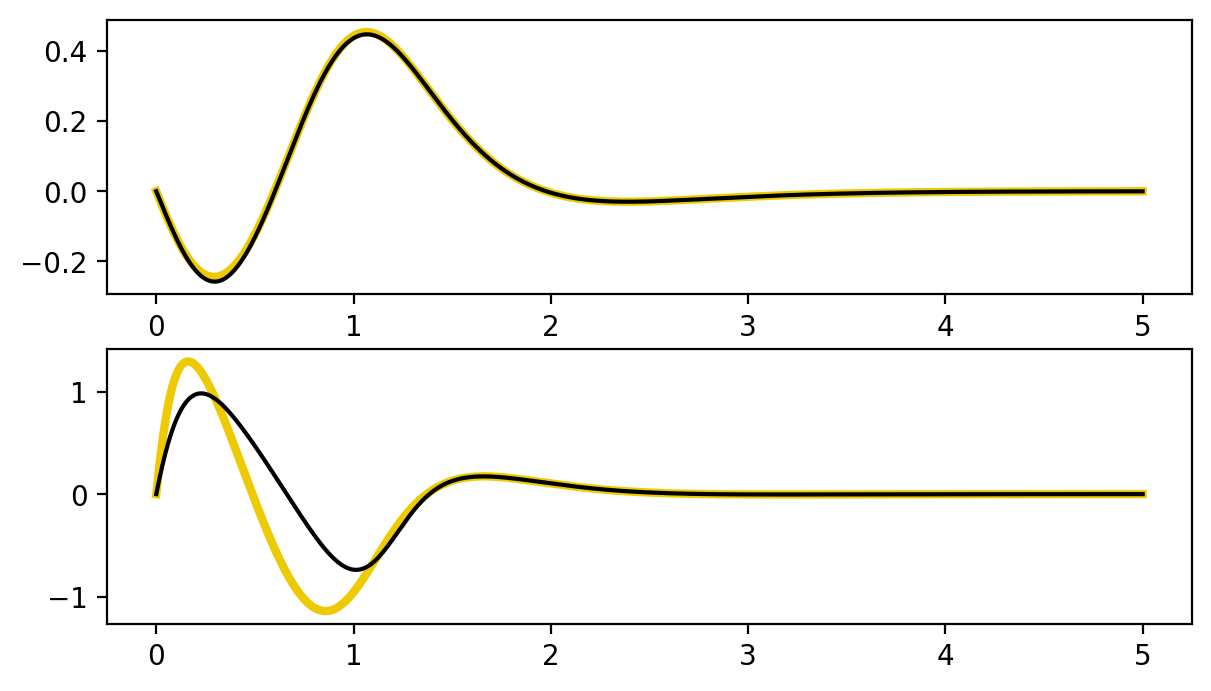

In [38]:


sol = solve_ivp(fun = lin_obs_ol,t_span=[0,5],y0=y0,t_eval=t,method='RK45',atol=1e-4,rtol=1e-4)

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,4))

ax0.plot(t,sol.y[5],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[1],c='black')

ax1.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
ax1.plot(t,sol.y[3],c='black')

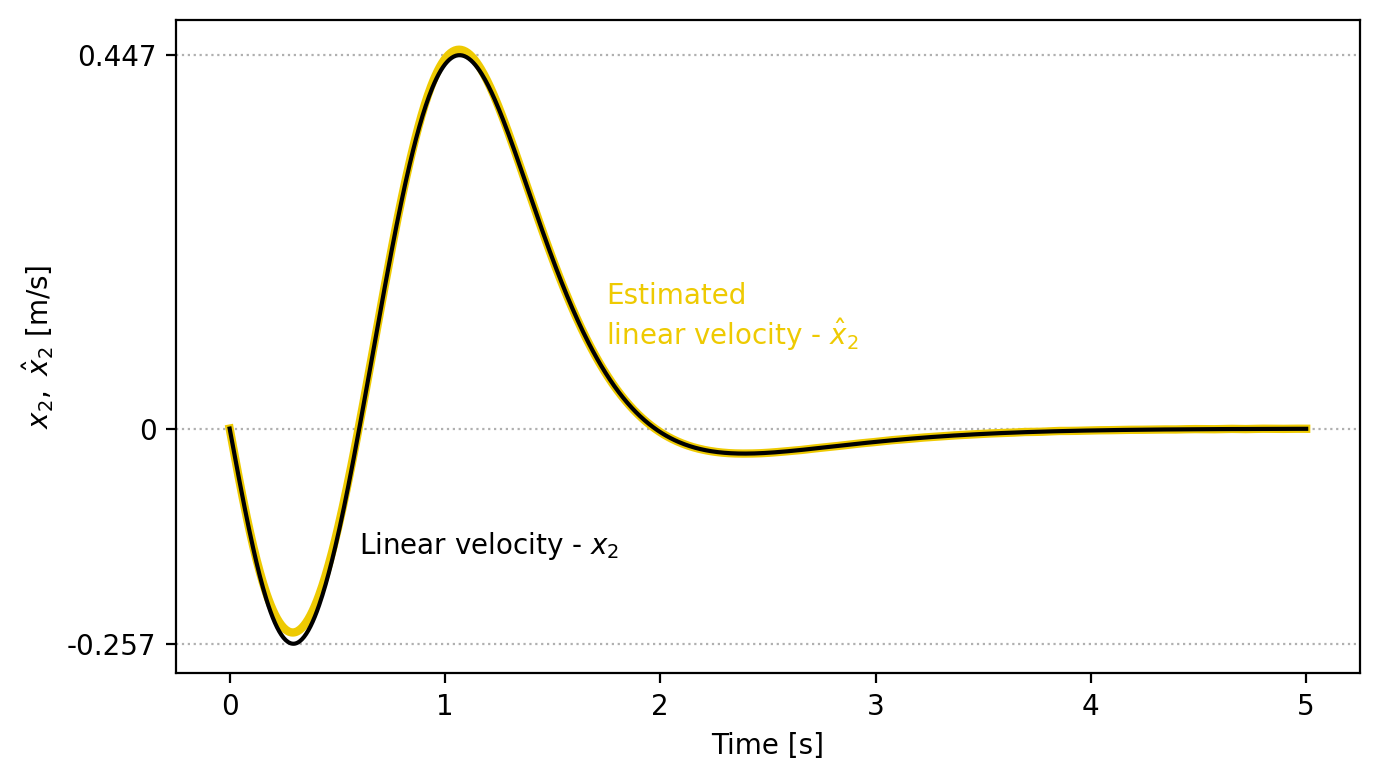

In [39]:


fig1,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[5],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[1],c='black')
ax0.set_yticks([1.0*min(sol.y[1]),0,1.0*max(sol.y[1])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[1])),'0','{:.3f}'.format(1.0*max(sol.y[1]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_2,\\ \\hat{x}_2$ [m/s]')
ax0.text(s='Linear velocity - $x_2$',x=0.6,y=-.15 )
ax0.text(s='Estimated\nlinear velocity - $\\hat{x}_2$',x=1.75,y=0.1,c=DARK )
fig1.tight_layout()
fig1.savefig('linear_ol_x2.pdf')
# ax1.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
# ax1.plot(t,sol.y[3],c='black')

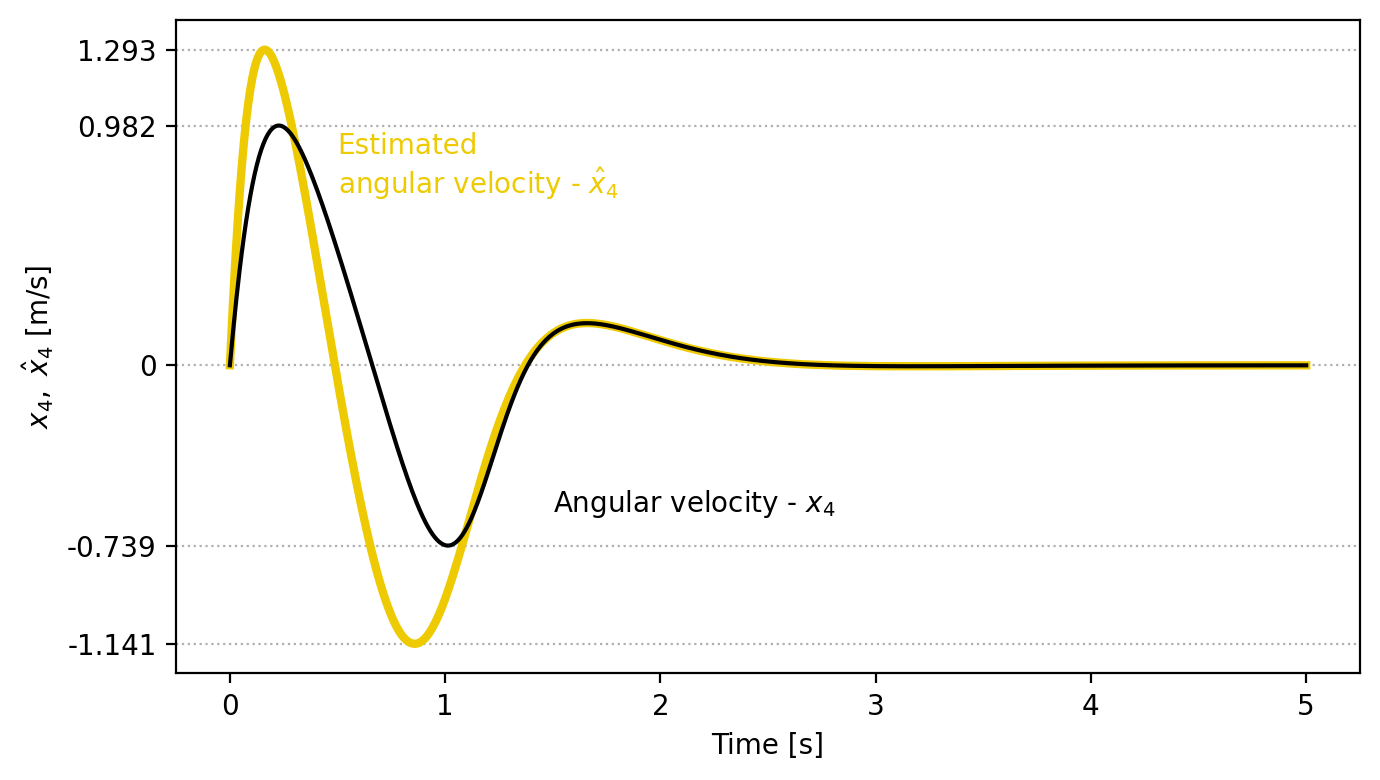

In [40]:
fig2,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[3],c='black')
ax0.set_yticks([1.0*min(sol.y[7]),1.0*min(sol.y[3]),0,1.0*max(sol.y[3]),1.0*max(sol.y[7])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[7])),'{:.3f}'.format(1.0*min(sol.y[3])),'0','{:.3f}'.format(1.0*max(sol.y[3])),'{:.3f}'.format(1.0*max(sol.y[7]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_4,\\ \\hat{x}_4$ [m/s]')
ax0.text(s='Angular velocity - $x_4$',x=1.5,y=-.6 )
ax0.text(s='Estimated\nangular velocity - $\\hat{x}_4$',x=.5,y=0.7,c=DARK )
fig2.tight_layout()
fig2.savefig('linear_ol_x4.pdf')

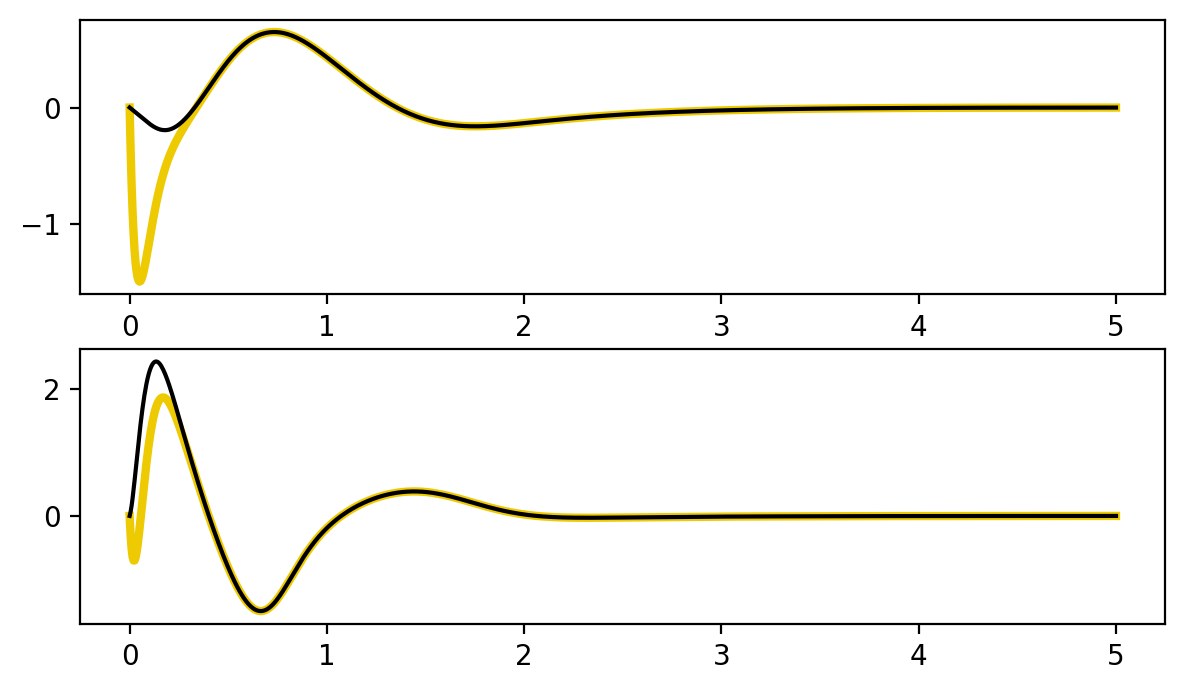

In [41]:
y0=np.zeros((8,))
y0[:4] = x0

sol = solve_ivp(fun = nln_obs_cl,t_span=[0,5],y0=y0,t_eval=t,method='RK45',atol=1e-4,rtol=1e-4)

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,4))

ax0.plot(t,sol.y[5],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[1],c='black')

ax1.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
ax1.plot(t,sol.y[3],c='black')

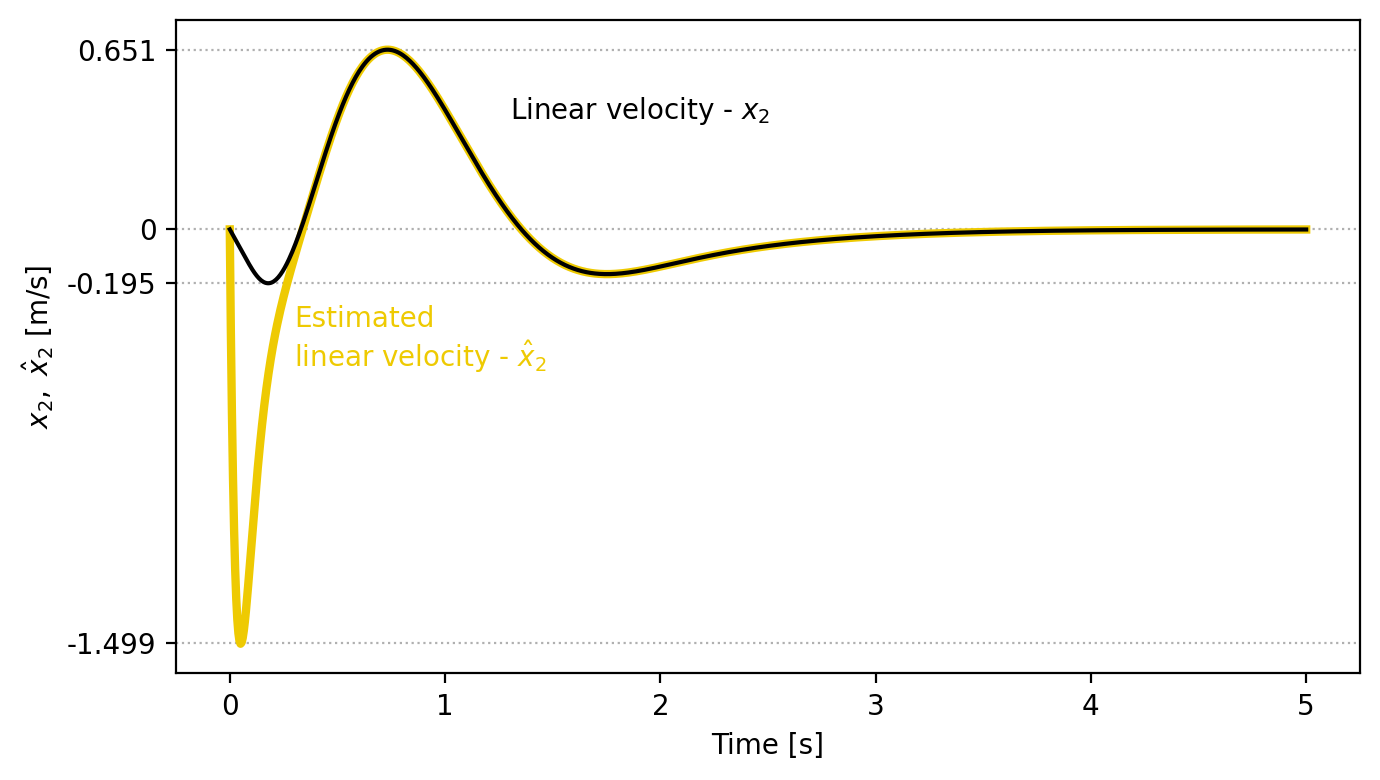

In [42]:


fig1,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[5],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[1],c='black')
ax0.set_yticks([1.0*min(sol.y[3]),1.0*min(sol.y[1]),0,1.0*max(sol.y[1])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[3])),'{:.3f}'.format(1.0*min(sol.y[1])),'0','{:.3f}'.format(1.0*max(sol.y[1]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_2,\\ \\hat{x}_2$ [m/s]')
ax0.text(s='Linear velocity - $x_2$',x=1.3,y=.4 )
ax0.text(s='Estimated\nlinear velocity - $\\hat{x}_2$',x=0.3,y=-.5,c=DARK )
fig1.tight_layout()
fig1.savefig('nonlinear_cl_x2.pdf')
# ax1.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
# ax1.plot(t,sol.y[3],c='black')

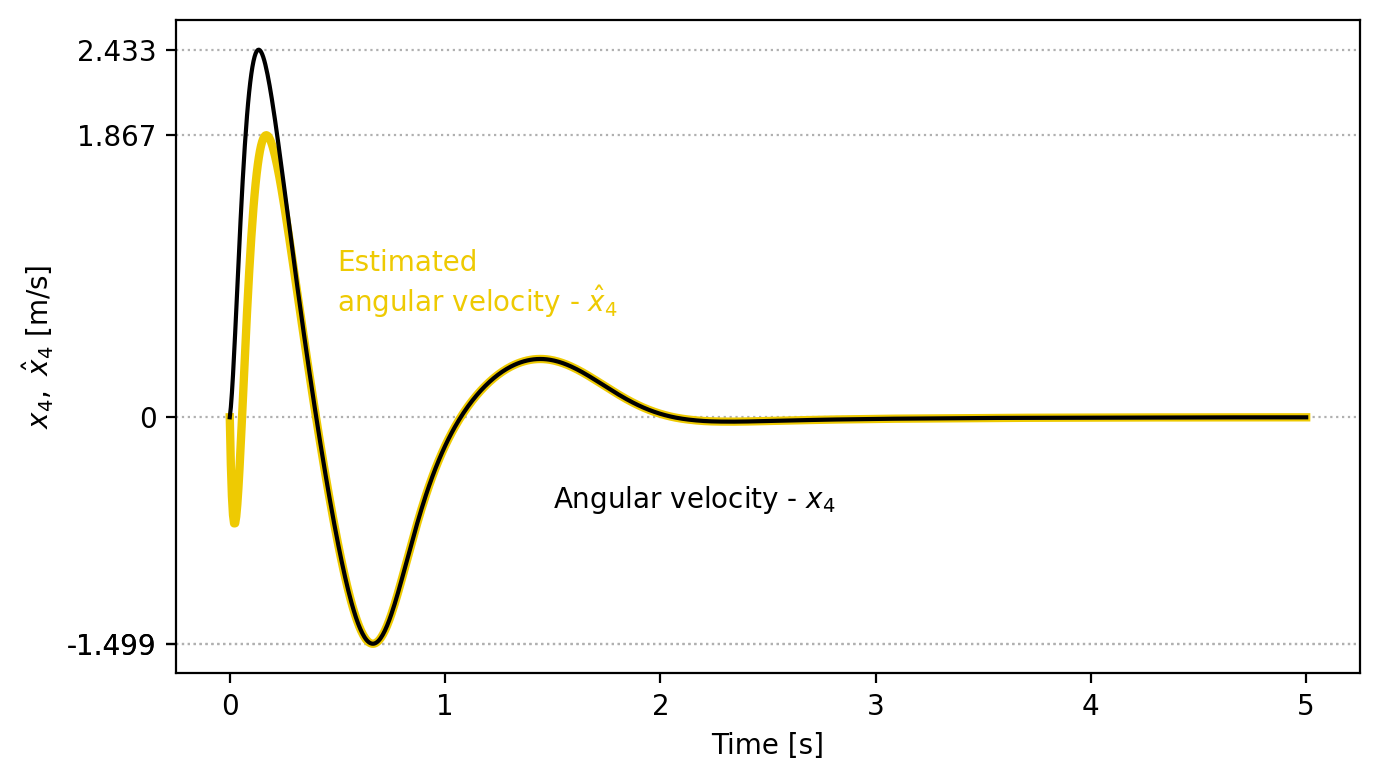

In [43]:
fig2,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[3],c='black')
ax0.set_yticks([1.0*min(sol.y[7]),1.0*min(sol.y[3]),0,1.0*max(sol.y[3]),1.0*max(sol.y[7])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[7])),'{:.3f}'.format(1.0*min(sol.y[3])),'0','{:.3f}'.format(1.0*max(sol.y[3])),'{:.3f}'.format(1.0*max(sol.y[7]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_4,\\ \\hat{x}_4$ [m/s]')
ax0.text(s='Angular velocity - $x_4$',x=1.5,y=-.6 )
ax0.text(s='Estimated\nangular velocity - $\\hat{x}_4$',x=.5,y=0.7,c=DARK )
fig2.tight_layout()
fig2.savefig('nonlinear_cl_x4.pdf')

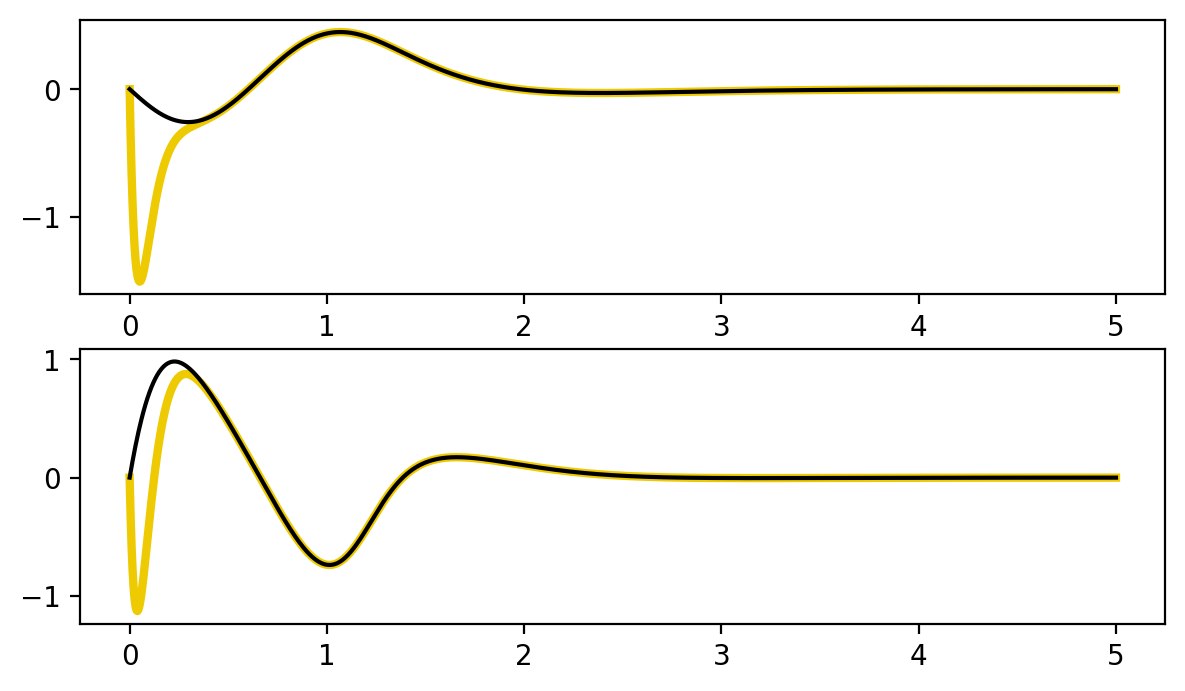

In [44]:

y0=np.zeros((8,))
y0[:4] = x0

sol = solve_ivp(fun = nln_obs_ol,t_span=[0,5],y0=y0,t_eval=t,method='RK45',atol=1e-4,rtol=1e-4)

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,4))

ax0.plot(t,sol.y[5],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[1],c='black')

ax1.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
ax1.plot(t,sol.y[3],c='black')

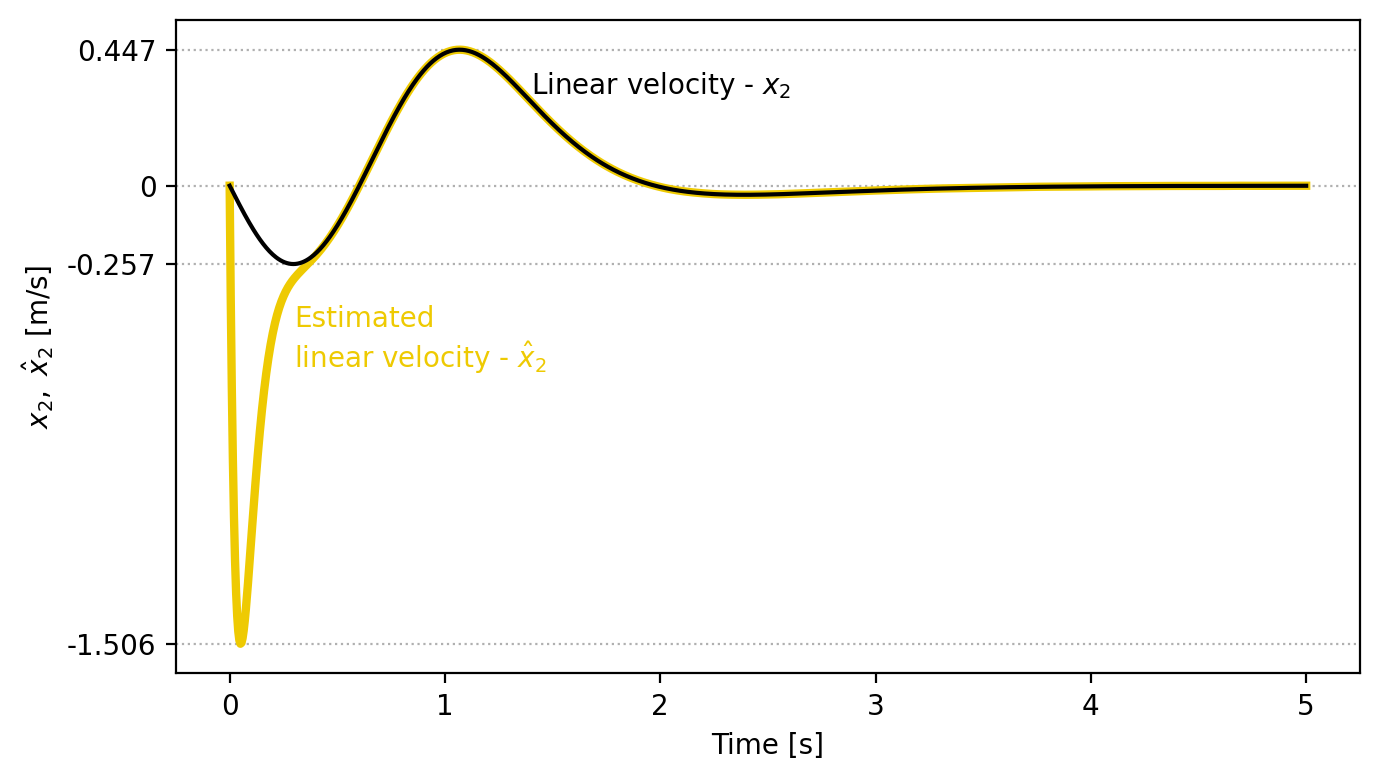

In [45]:


fig1,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[5],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[1],c='black')
ax0.set_yticks([1.0*min(sol.y[5]),1.0*min(sol.y[1]),0,1.0*max(sol.y[1])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[5])),'{:.3f}'.format(1.0*min(sol.y[1])),'0','{:.3f}'.format(1.0*max(sol.y[1]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_2,\\ \\hat{x}_2$ [m/s]')
ax0.text(s='Linear velocity - $x_2$',x=1.4,y=.3 )
ax0.text(s='Estimated\nlinear velocity - $\\hat{x}_2$',x=0.3,y=-.6,c=DARK )
fig1.tight_layout()
fig1.savefig('nonlinear_ol_x2.pdf')
# ax1.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
# ax1.plot(t,sol.y[3],c='black')

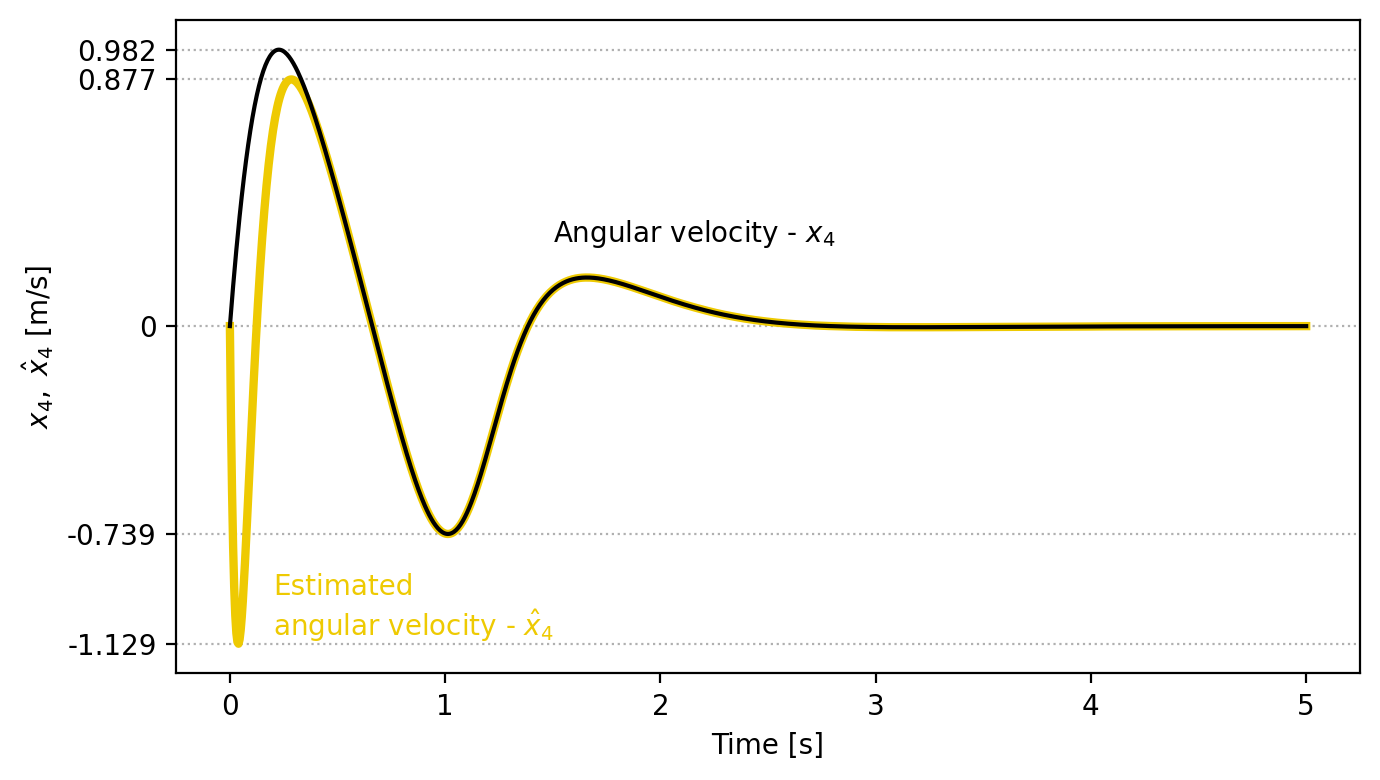

In [46]:
fig2,ax0 = plt.subplots(1,1,figsize=(7,4))

ax0.plot(t,sol.y[7],c=DARK, linewidth=3, zorder=2)
ax0.plot(t,sol.y[3],c='black')
ax0.set_yticks([1.0*min(sol.y[7]),1.0*min(sol.y[3]),0,1.0*max(sol.y[3]),1.0*max(sol.y[7])])
ax0.set_yticklabels(['{:.3f}'.format(1.0*min(sol.y[7])),'{:.3f}'.format(1.0*min(sol.y[3])),'0','{:.3f}'.format(1.0*max(sol.y[3])),'{:.3f}'.format(1.0*max(sol.y[7]))])
ax0.grid(axis='y',linestyle=':')
ax0.set_xlabel('Time [s]')
ax0.set_ylabel('$x_4,\\ \\hat{x}_4$ [m/s]')
ax0.text(s='Angular velocity - $x_4$',x=1.5,y=.3 )
ax0.text(s='Estimated\nangular velocity - $\\hat{x}_4$',x=.2,y=-1.1,c=DARK )
fig2.tight_layout()
fig2.savefig('nonlinear_ol_x4.pdf')

/opt/anaconda3/envs/DA2021/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/opt/anaconda3/envs/DA2021/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/opt/anaconda3/envs/DA2021/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


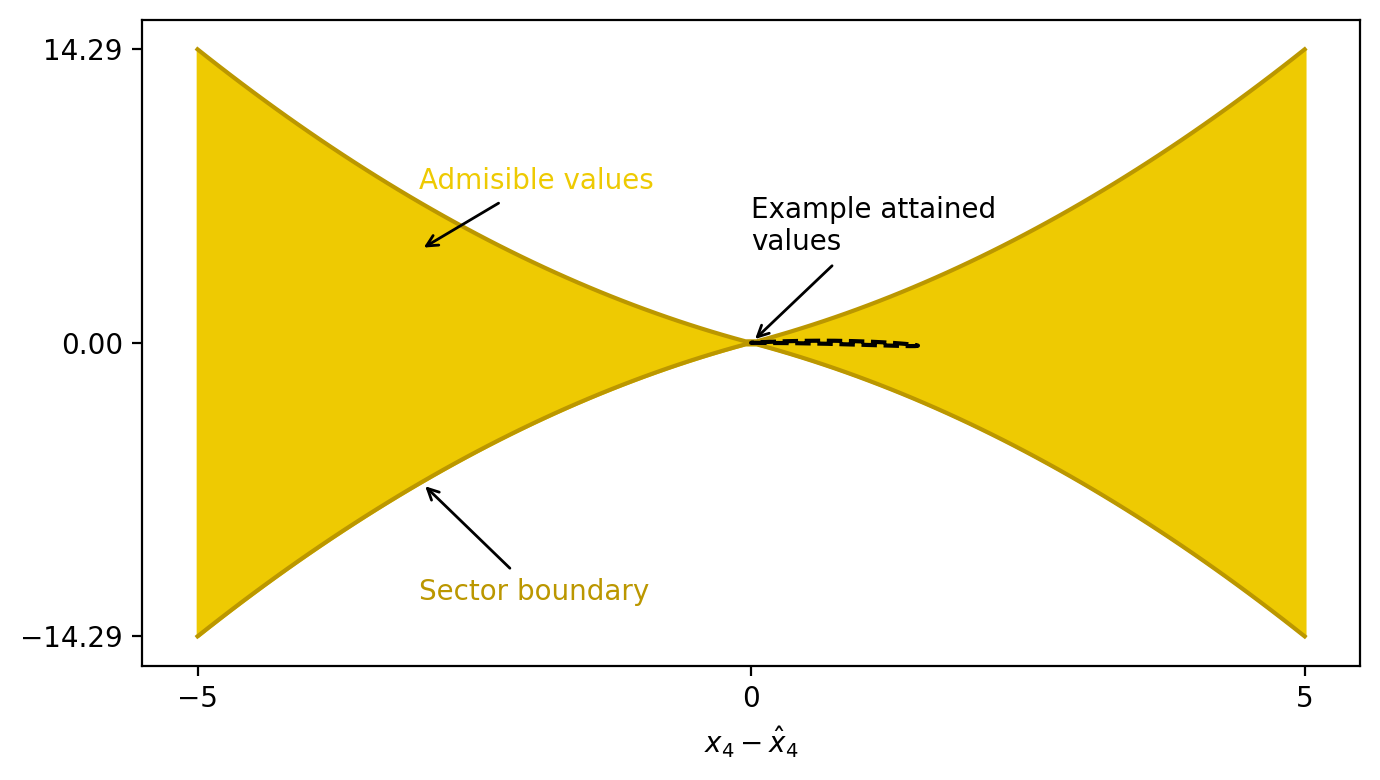

In [51]:
import itertools  

a2=0.7143
x1_max = 0.4
x4_max = 2.5
x1s=[x1_max,-x1_max]
x4s=[x4_max,-x4_max]
tuples = list(itertools.product(x1s, x4s))
v = np.linspace(-5,5,100)
lb=[]
ub=[]

fvt = lambda v, tup: a2*tup[0]*(v**2-2*tup[1]*v)
for v_star in v:
    fvt_tup = lambda tup: fvt(v_star,tup)    
    values = [*map(fvt_tup,tuples)]
    lb.append(min(values))
    ub.append(max(values))
fig,ax = plt.subplots(1,1,figsize = (7,4))
ax.plot(v,lb,c=DARK_HIGHLIGHT)
ax.plot(v,ub,c=DARK_HIGHLIGHT)
ax.fill_between(v,lb,ub,color=DARK)
ax.set_xlabel('$x_4-\\hat{x}_4$')

v_exp = sol.y[3] - sol.y[7]
fun_exp = a2*sol.y[0]*(v_exp**2-2*sol.y[3]*v_exp)
ax.plot(v_exp,fun_exp,c='black',linestyle = '--')
ax.annotate(s='Sector boundary',xy=(v[20],lb[20]),xytext=(-3,-12.5),arrowprops={'arrowstyle':'->','color':'black'}, c=DARK_HIGHLIGHT)
ax.annotate(s='Admisible values',xy=(-3,4.5),xytext=(-3,7.5),arrowprops={'arrowstyle':'->','color':'black'}, c=DARK)
ax.annotate(s='Example attained\nvalues',xy=(v_exp[159],fun_exp[159]),xytext=(0,4.5),arrowprops={'arrowstyle':'->','color':'black'}, c='black')
ax.set_yticks([min(lb),0,max(ub)])
ax.set_xticks([-5,0,5])
fig.tight_layout()
fig.savefig('sektor.pdf')

In [48]:

a = [1, 2, 3]
b = [4, 5, 6]
c = list(itertools.product(a, b))

In [49]:
b1=0.0365
m=0.208
r=0.018
Jb=m*(b1-7/5*r**2)

In [50]:
print(Jb)

0.007497651199999999
